In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from riesling_utils import imshow3, read_radial_h5, plot_3plane, load_nii

plt.rcParams['font.size'] = 16

# Introduction
This demo will go through the basic funcionality in `riesling` using a phantom example. `riesling` will be executed as a commandline tool and basic methods for integration with python are demonstrated as well.

The following commands are available in `riesling`

In [2]:
!riesling -h

  riesling COMMAND {OPTIONS}

    RIESLING

  OPTIONS:

      COMMANDS
        cg                                cgSENSE/Iterative recon w/ Töplitz
                                          embedding
        cgvar                             cgSENSE with variable preconditioning
        compress                          Apply channel compression
        ds                                Direct Summation (NUFT)
        grid                              Grid from/to non-cartesian to/from
                                          cartesian
        hdr                               Print the header from an HD5 file
        phantom                           Construct a digitial phantom
        plan                              Plan FFTs
        rss                               Recon w/ root-sum-squares channel
                                          combo
        sdc                               Calculate Sample Density Compensation
        sense                             Recon w/ sel

The commands will be exectued without verbose mode on here to reduce stdout output, but if you want to get a better idea of what is happening, add `-v`. If you want even more info set `--verbosity 1/2/3`, at the highest level you will get intermediate image files saved as well, such as iterations in iterative methods.

## Table of contents

- [1. Generate a phantom](#gen_phantom)
- [2. The H5 format](#h5_hdr_data_traj)
    - [2.1 Look at the raw data, header, and trajectory using riesling](#h5_riesling)
    - [2.2 Import the data into python](#h5_python)
- [3. Root sum of squares reconstruction](#rss_recon)
- [4. SENSE Reconstruction](#sense_recon)
    - [4.1 Coil compression](#coil_compress)
- [5. Iterative Reconstruction](#iterative_recon)
    - [5.1 Conjugate Gradients](#cg_sense)
    - [5.2 Total Generalised Variation](#tgv)
- [6. Gridding methods](#gridding_methods)



<a href='gen_phantom'></a>
## 1. Generate a Phantom

We start by generating a 3D Shepp Logan phantom which will be used for this demonstration. We use a 

- `mat`: Matrix size of 128 which results in a nominal number of spokes $N_{nom} = MAT^2\cdot \pi=51471$. In `riesling` we assume a factor of $\pi$ undersampling is fully sampled. We therefore ignore this factor. 
- `srate`: We undersample in the angular direction by $\pi$ and an additional 25%.
- `lrate`: Scale factor for gradient amplitude in low-resolution spokes for filling deadtime gap. Will also set the number of low-res spokes.
- `snr`: SNR of 50
- `gap`: Dead-time gap of 3


In [3]:
mat=128
nspokes_nom=mat**2
srate = 0.75
lrate = 8
nspokes = int(nspokes_nom*srate)
snr = 50
gap = 3
nspokes_low = int(nspokes/lrate)

In [4]:
!riesling phantom --shepp_logan --gap {gap} -l {lrate} -m {mat} --spokes={srate} --snr {snr} sl_phantom

**Note!** `riesling` utilise the FFTW library to calculate FFTs. FFTW use a planner function to optimise the FFT calculation for your system and different data structures. The first time you calculate a new FFT you will therefore notice a longer computational time. The next time it will be a lot faster!

This will create a file called `sl_phantom.h5` which contains the radial k-space data, the header information, and the trajectory. 

To do a simple reconstruction we use `rss` (which will be discussed more later).

In [5]:
!riesling rss sl_phantom.h5

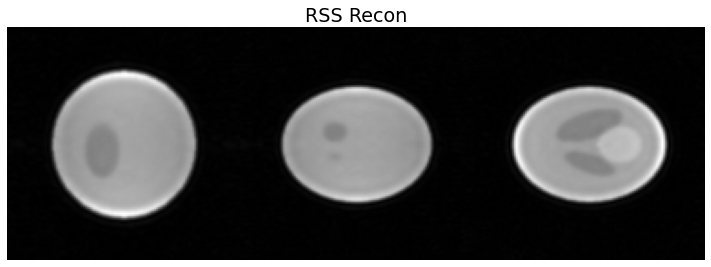

In [6]:
plt.figure(figsize=(12,4))
plot_3plane(load_nii('sl_phantom-rss.nii'), ix=50, iy=50, iz=50)
plt.title('RSS Recon')
plt.tight_layout()
plt.show()

<a href='h5_hdr_data_traj'></a>
## 2. H5 format - Header, Data, Trajectory
The `.h5` format used in `riesling` is a simple data structure containing the radial k-space data, trajectory and meta data. Below we demonstrate how to look at the data structure using `riesling` and then with python.


<a href='h5_riesling'></a>
### 2.1 Using `riesling`
First let's have a look at the trajectory in the .h5 file

In [19]:
!riesling traj sl_phantom.h5

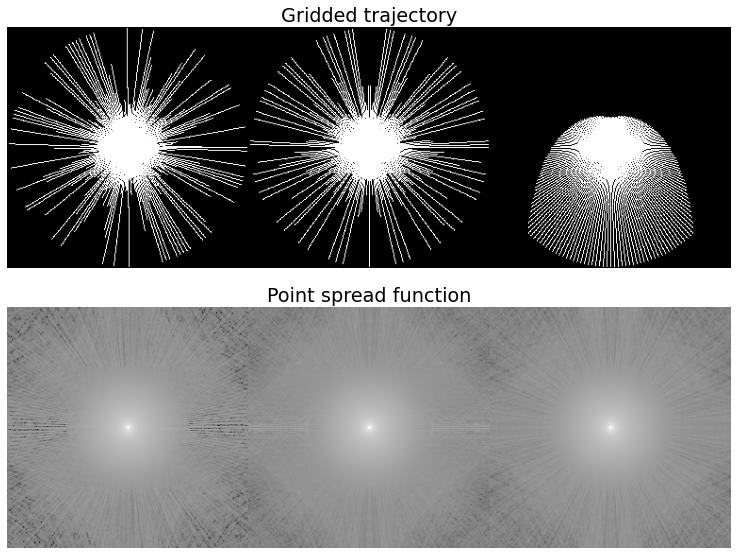

In [20]:
traj_nii = load_nii('sl_phantom-traj.nii')
psf_nii = load_nii('sl_phantom-psf.nii')

fig = plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plot_3plane(traj_nii, vmin=0, vmax=1)
plt.title('Gridded trajectory')

plt.subplot(2,1,2)
plot_3plane(np.log(abs(psf_nii)+1E-20))
plt.title('Point spread function')

plt.tight_layout()
plt.show()

<a id='h5_python'></a>
### 2.2 Read radial h5 file into python
In some cases you might want to look at the raw data yourself in python for debugging or to do other recon. Since we use a standard HDF5 file it is easy to read in the data using the `h5py` library.

In [25]:
import h5py

In [27]:
f = h5py.File("sl_phantom.h5",'r')
f.keys()

<KeysViewHDF5 ['info', 'noncartesian', 'trajectory']>

In [49]:
info = f['info'][:]
trajectory = f['trajectory'][:]
data = f['noncartesian'][:]

The `info` structure is a numpy array where each entry has a special datatype with an associated name and data format.

In [51]:
for k in info.dtype.names:
    print("{}: {}".format(k, info[k]))

matrix: [[128 128 128]]
voxel_size: [[1.875 1.875 1.875]]
read_points: [128]
read_gap: [3]
spokes_hi: [12288]
spokes_lo: [1536]
lo_scale: [8.]
channels: [12]
type: [1]
volumes: [1]
tr: [1.]
origin: [[-120. -120. -120.]]
direction: [[1. 0. 0. 0. 1. 0. 0. 0. 1.]]


You can access elements using the names like a dictionary

In [46]:
info['matrix']

array([[128, 128, 128]])

The trajectory is a numpy array with order [spokes, readout, dimension]

In [48]:
print("Trajectory shape: {}".format(trajectory.shape))

Trajectory shape: (13824, 128, 3)


The data is stored such that, if you like to, you can access it through hyperslabs. Here we read in all of it at once. It has the shape of [1, spokes, readout, coils]

In [50]:
print("Data shape: {}".format(data.shape))

Data shape: (1, 13824, 128, 12)


Let's have a look at the data and the trajectory

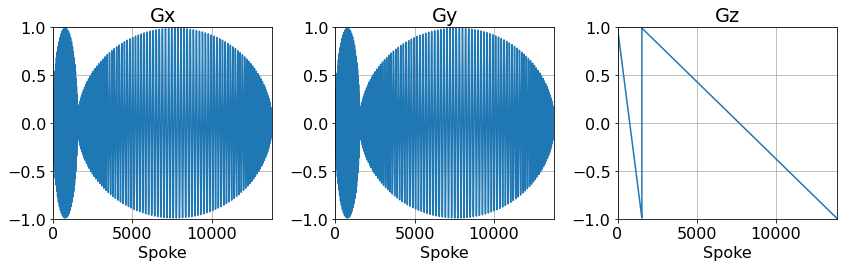

In [55]:
fig = plt.figure(figsize=(12,4))

for (i,G) in enumerate(['Gx', 'Gy', 'Gz']) :
    fig.add_subplot(1,3,i+1)
    plt.plot(trajectory[:,-1,i])
    plt.title(G); plt.xlabel('Spoke')
    plt.axis([0,info['spokes_hi']+info['spokes_lo'],-1,1]); plt.grid('on')
    
plt.tight_layout()
plt.show()

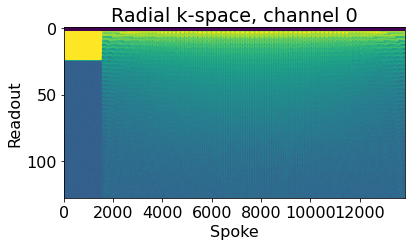

In [59]:
plt.figure()
coilidx=0
plt.imshow(np.log(np.abs(data[0,:,:,coilidx])+1E-10).T, aspect=(data.shape[1]/data.shape[2])/2, vmin=0, vmax=10)
plt.title('Radial k-space, channel %d'%coilidx)
plt.xlabel('Spoke'); plt.ylabel('Readout')
plt.tight_layout()
plt.show()

In both the trajectory and data plotted here we see the low-resolution spokes acquired in the beginning which are used to fill the deadtime gap.

<a id='rss_recon'></a>
## 3. Root sum of squares reconstruction
The simplest reconstruction we can run is gridding followed by root sum of squares coil combination. For this we use `rss`

In [60]:
!riesling rss sl_phantom.h5

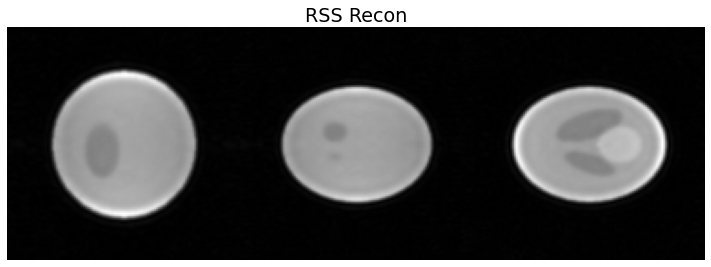

In [61]:
plt.figure(figsize=(12,4))
plot_3plane(load_nii('sl_phantom-rss.nii'), ix=50, iy=50, iz=50)
plt.title('RSS Recon')
plt.tight_layout()
plt.show()

<a id='sense_recon'></a>
## 4. SENSE Reconstruction
The next step is to do a SENSE reconstruction where we estimate coil sensitivity maps and do a complex coil combination. This is implemented in `sense`.

In [62]:
!riesling sense --maps --channels sl_phantom.h5

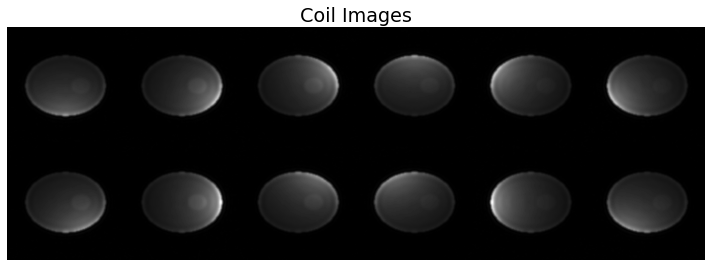

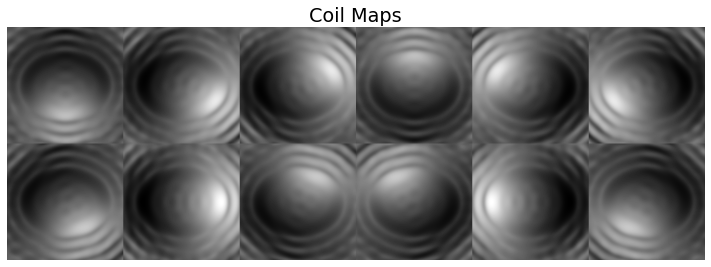

In [63]:
plt.figure(figsize=(12,4))

imshow3(abs(load_nii('sl_phantom-sense-channels.nii')[:,:,64,:]), ncol=6, nrow=2)
plt.title("Coil Images")
plt.tight_layout()

plt.figure(figsize=(12,4))
imshow3(abs(load_nii('sl_phantom-sense-maps.nii')[:,:,64,:]), ncol=6, nrow=2)
plt.title("Coil Maps")
plt.tight_layout()

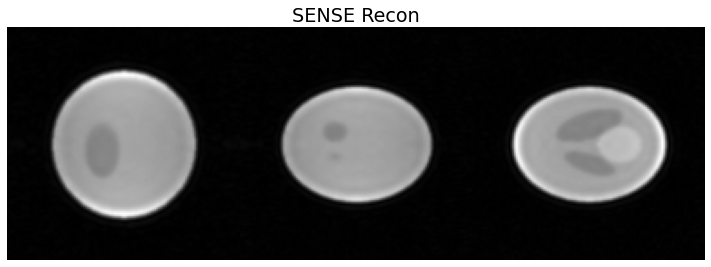

In [64]:
plt.figure(figsize=(12,4))
plot_3plane(abs(load_nii('sl_phantom-sense.nii')), ix=50, iy=50, iz=50)
plt.title('SENSE Recon')
plt.tight_layout()

<a id='coil_compress'></a>
### 4.1 Coil Compression
There is functionality to compress raw k-space data to fewer coils with the `compress` command

In [65]:
!riesling compress --cc 8 sl_phantom.h5
!riesling sense sl_phantom-compressed.h5 --maps --channels

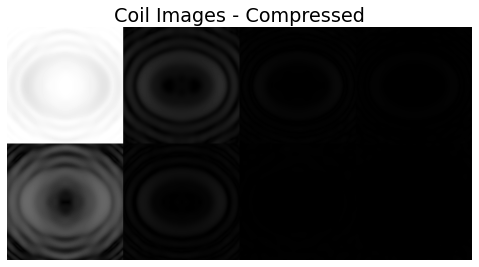

In [66]:
plt.figure(figsize=(12,4))
imshow3(abs(load_nii('sl_phantom-compressed-sense-maps.nii')[:,:,64,:]), ncol=4, nrow=2, vmin=0, vmax=1)
plt.title("Coil Images - Compressed")
plt.tight_layout()

<a id='iterative_recon'></a>
## 5. Iterative Reconstruction
For iterative recon we have two options, conjugate-gradient sense (in `cg`) or total generalised variation (in `tgv`). Both these methods have the `-i` option to decide the number of interations. Note that these methods are computationally heavy and we use few iterations here as a proof of concept.

<a id='cg_sense'></a>
### 5.1 Conjugate Gradients - CG-SENSE
The conjugate gradient method is a popular reconstruction method which recently was highlighted in the [2020 Reproducibility Studygroup reconstruction challenge](https://onlinelibrary.wiley.com/doi/10.1002/mrm.28569).

In [69]:
!riesling cg -i 5 --sdc=pipe sl_phantom.h5

<a id='tgv'></a>
### 5.2 TGV
For the TGV method there are several additional parameters which sets the level of regularisation. 

- `--l1`: $L_1$ Regularisation weighting (Default $10^{-5}$
- `--l1reduce`: Reduce $L_1$ by factor over iteations (suggested 0.1)
- `--step`: Inverse of step size (default 8)

It is likely you will have to tweak these parameters to get the best result for your application.

In [72]:
!riesling tgv -i 10 --sdc=pipe sl_phantom.h5 --alpha 5E-6

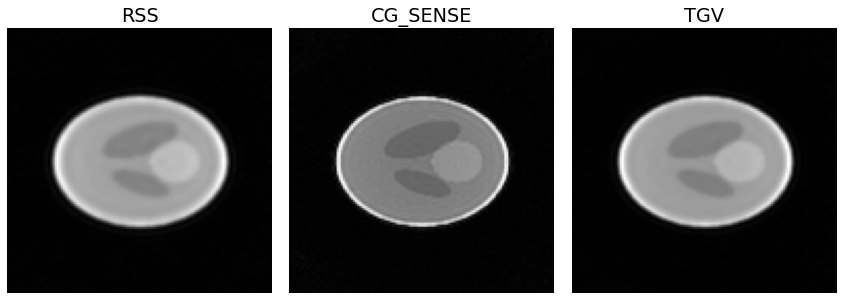

In [73]:
plt.figure(figsize=(12,8))

plt.subplot(1,3,1)
plt.imshow(load_nii('sl_phantom-rss.nii')[:,:,50], cmap='gray'); plt.axis('off')
plt.title('RSS')

plt.subplot(1,3,2)
plt.imshow(abs(load_nii('sl_phantom-cg.nii')[:,:,50]), cmap='gray'); plt.axis('off')
plt.title('CG_SENSE')

plt.subplot(1,3,3)
plt.imshow(abs(load_nii('sl_phantom-tgv.nii')[:,:,50]), cmap='gray'); plt.axis('off')
plt.title('TGV')

plt.tight_layout()
plt.show()

<a id='gridding_methods'></a>
## 6. Gridding Methods
All reconstruction tools in `riesling` include two different gridding methods

- Nearest-Neighbor, aka. NN, (Default) - [Oesterle et al. 1999](https://onlinelibrary.wiley.com/doi/10.1002/(SICI)1522-2586(199907)10:1%3C84::AID-JMRI12%3E3.0.CO;2-D)
- Kaiser-Bessel kernel (Option `--kb` with kernel width set by `--kw`, default to 3) - [Beatty et al. 2005](https://ieeexplore.ieee.org/document/1435541)

For 3D reconstructions, NN gridding works very well and gives very similar results to KB but in shorter time. Let's do a quick comparison

In [76]:
!time `riesling cg -i 5 sl_phantom.h5 -o sl_phantom_NN`


real	0m12.032s
user	2m34.220s
sys	0m7.463s


In [77]:
!time `riesling cg -i 5 --kb sl_phantom.h5 -o sl_phantom_KB`


real	0m17.095s
user	4m2.448s
sys	0m8.125s


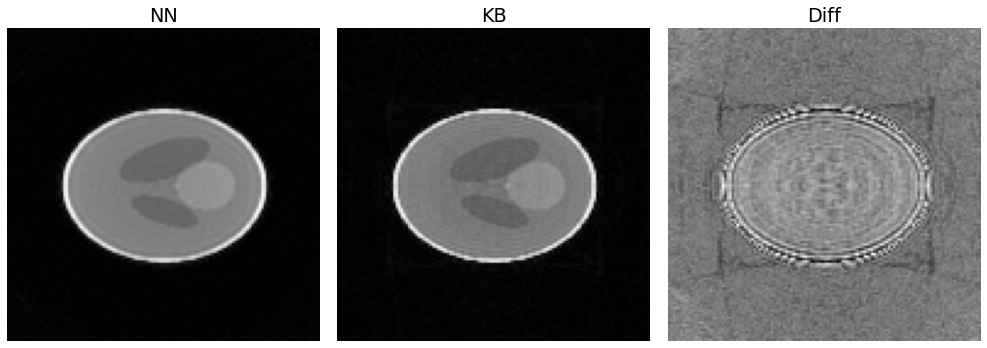

In [78]:
plt.figure(figsize=(14,8))

plt.subplot(1,3,1)
plt.imshow(abs(load_nii('sl_phantom_NN-cg.nii')[:,:,50]), cmap='gray'); plt.axis('off')
plt.title('NN')

plt.subplot(1,3,2)
plt.imshow(abs(load_nii('sl_phantom_KB-cg.nii')[:,:,50]), cmap='gray'); plt.axis('off')
plt.title('KB')

plt.subplot(1,3,3)
plt.imshow(
    abs(load_nii('sl_phantom_NN-cg.nii')[:,:,50])-abs(load_nii('sl_phantom_KB-cg.nii')[:,:,50]), 
    cmap='gray'); plt.axis('off')
plt.title('Diff')

plt.tight_layout()
plt.show()

<a id='density_compensation'></a>
## 8. Density Compensation
An accurate estimate of density compensation is important for high quality image reconstruction in non-cartesian imaging. For a simple radial acquisition the density compensation can be analytically approximated by the surface area of a sphere at the sample radii, resulting in a $r^2$ density compensation. This only holds true for evenly distributed spokes/points.

A more accurate, and generalisable, method is the sample density compensation (SDC) method proposed by [Pipe and Menon](https://onlinelibrary.wiley.com/doi/10.1002/(SICI)1522-2594(199901)41:1%3C179::AID-MRM25%3E3.0.CO;2-V). This method is implemented in `riesling` and used with the `--sdc=pipe` flag. For highly undersampled acquisition, this type of density compensation will produce images that might appear more blurred as the edges of k-space will be down-weighted according to the true sample density. However, a true density compensation will accelerate convergence for iterative methods such as CG-SENSE and TGV.

That's all we have for now! Hope it was helpful and that you have got started with `riesling` for your own project.